In [1]:
from Utils.loadset import getDataSet
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_probability as tfp
import os
physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices)) 

from trainer import Trainer
try:
    from Utils.connection_cfg import *
except Exception as e:
    PSWD = None
    USRN = None
    
from Utils.Data import dataWrapper

Num GPUs: 1
Num GPUs Available: 1


Using TensorFlow backend.


In [6]:
dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-5 )
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true[:,:])
                           
def mixd(output):
    rate = tf.math.exp(output[0,:,:,0]) #A 
    s = tf.math.sigmoid(output[0,:,:,1])
    components = [tfd.Deterministic(loc=tf.zeros_like(rate)), #E
     tfd.Poisson(rate=rate) #F 
     ]
    mixture = tfd.Mixture(
          cat=tfd.Categorical(probs=tf.stack([1-s, s],axis=-1)),#D
          components=components)
    
    return mixture
    
def testnetPoisson(input_shape,
           n_predictions=1,
           simpleclassification=None,
           flatten_output=False,
           activation_hidden="relu",
           activation_output="relu"):


    inputs = Input(shape=input_shape) 

    conv01 = Conv2D(10, kernel_size=(3, 3), padding="same")(inputs)       # 10 x 64x64
    conv01 = Activation(activation_hidden)(conv01)
    conv01_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv01)            # 10 x 32x32


    conv02 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv01_pool)  # 20 x 32x32
    conv02 = Activation(activation_hidden)(conv02)
    conv02_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv02)            # 20 x 16x16


    conv03 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv02_pool)  # 20 x 16x16
    conv03 = Activation(activation_hidden)(conv03)
    conv03_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv03)            # 20 x 8x8


    conv04 = Conv2D(20, kernel_size=(3, 3), padding="same")(conv03_pool)  # 20 x 8x8
    conv04 = Activation(activation_hidden)(conv04)
    conv04_pool = MaxPooling2D((2, 2), strides=(2, 2))(conv04)            # 20 x 4x4


    ### UPSAMPLING:
    up04 = UpSampling2D((2, 2))(conv04_pool)    # 20 x 8x8
    up04 = concatenate([conv04, up04], axis=3)  # 20+20 x 8x8


    up03 = UpSampling2D((2, 2))(up04)           # 40 x 16x16
    up03 = concatenate([conv03, up03], axis=3)  # 20+40 x 16x16


    up02 = UpSampling2D((2, 2))(up03)           # 60 x 32x32
    up02 = concatenate([conv02, up02], axis=3)  # 20+60 x 32x32


    up01 = UpSampling2D((2, 2))(up02)           # 80 x 64x64
    up01 = concatenate([conv01, up01], axis=3)  # 10+80 x 64x64


    output = Conv2D(1, (1, 1), activation=tf.exp)(up01)  # 1 x 64x64
    #output = tfpl.IndependentBernoulli((1), tfd.Bernoulli.logits)(output)
    
    output = tfp.layers.IndependentPoisson(1)(output)
    model = Model(inputs=inputs, outputs=output)
    return model

def provideData(flatten=False,dimension=dimension,batch_size=10,transform=None,preTransformation=None):

    getDataSet(DatasetFolder,year=[2017],username=USRN,pswd=PSWD)
    train,test = dataWrapper(PathToData,
                            dimension=dimension,
                            channels=channels,
                            batch_size=batch_size,
                            overwritecsv=True,
                            flatten=flatten,
                            onlyUseYears=[2017],
                            transform=transform,
                            preTransformation=preTransformation)
    
    return train,test
DatasetFolder = "./Data/RAW"
PathToData = os.path.join(DatasetFolder,"MonthPNGData")

In [7]:
dimension = (64,64)
channels = 5
optimizer = Adam( lr = 1e-4 )
tfd = tfp.distributions
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

train, test = provideData(flatten=False,dimension=dimension,batch_size=1,transform=None,preTransformation=None)

Found Year :  2017 => won't download this year again... please check for consistency
Finished Loading Dataset
 


In [8]:
t = Trainer(testnetPoisson,
                    NLL,
                    (train,test),
                    batch_size = 1,
                    optimizer=optimizer,
                    dimension = dimension,
                    channels = channels,
                    metrics = ["mse","mae"])

print("len train,val",len(train),len(test))

[Load file failed]  ./model_data/testnetPoisson_function/testnetPoisson_function64x64x5.h5
[Load file failed]  ./model_data/testnetPoisson_function/testnetPoisson_function64x64x5history.json
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 5)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 10)   460         input_2[0][0]                    
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 64, 64, 10)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
ma

In [9]:
t.fit(100)
model = t.model


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 10 steps
Epoch 1/100
10/10 [==============================] - 2s 193ms/step - loss: 2.7325 - mse: 10.4261 - mae: 2.7126 - val_loss: 9.3666 - val_mse: 169.7664 - val_mae: 5.6490
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 2.7020 - mse: 10.2308 - mae: 2.6865 - val_loss: 9.7537 - val_mse: 176.6970 - val_mae: 5.6931
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 2.6737 - mse: 10.0665 - mae: 2.6571 - val_loss: 9.6367 - val_mse: 169.0436 - val_mae: 5.5506
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 2.6389 - mse: 9.9743 - mae: 2.6279 - val_loss: 9.4646 - val_mse: 158.9215 - val_mae: 5.3780
Epoch 5/100
10/10 [==============================] - 0s 8ms/step - loss: 2.5842 - mse: 9.4207 - mae: 2.5571 - val_loss: 10.0619 - val_mse: 170.7255 - val_mae: 5.4341
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 2.5

Epoch 49/100
10/10 [==============================] - 0s 8ms/step - loss: 1.1483 - mse: 2.8501 - mae: 1.0783 - val_loss: 11.4922 - val_mse: 181.2767 - val_mae: 4.5415
Epoch 50/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1535 - mse: 2.8916 - mae: 1.0799 - val_loss: 11.0914 - val_mse: 171.5392 - val_mae: 4.4267
Epoch 51/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1483 - mse: 2.8609 - mae: 1.0761 - val_loss: 11.0797 - val_mse: 170.6919 - val_mae: 4.4245
Epoch 52/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1529 - mse: 2.8941 - mae: 1.0718 - val_loss: 10.6969 - val_mse: 160.9369 - val_mae: 4.3296
Epoch 53/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1507 - mse: 2.8601 - mae: 1.0737 - val_loss: 11.4308 - val_mse: 179.5861 - val_mae: 4.5256
Epoch 54/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1505 - mse: 2.8971 - mae: 1.0889 - val_loss: 11.0803 - val_mse: 170.8653 - val_mae: 4.428

10/10 [==============================] - 0s 9ms/step - loss: 1.1492 - mse: 2.8418 - mae: 1.0696 - val_loss: 11.4411 - val_mse: 179.6369 - val_mae: 4.5235
Epoch 99/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1490 - mse: 2.8506 - mae: 1.0769 - val_loss: 10.7115 - val_mse: 161.4698 - val_mae: 4.3292
Epoch 100/100
10/10 [==============================] - 0s 9ms/step - loss: 1.1497 - mse: 2.8751 - mae: 1.0746 - val_loss: 11.4259 - val_mse: 179.1952 - val_mae: 4.5099


     |████████████████████████████████| 12.4 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 88 kB 1.7 MB/s  eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


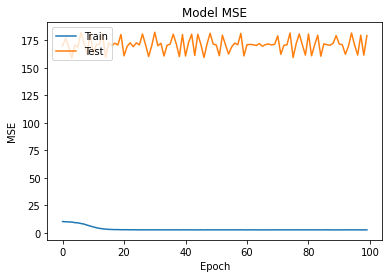

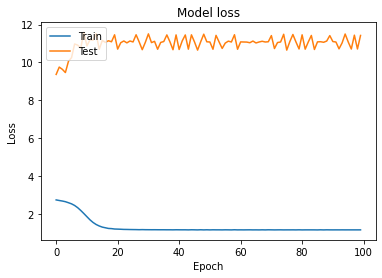

In [11]:
!pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import figure
import numpy as np
%matplotlib inline
history = t.history
def plotHistory():
    # Plot training & validation accuracy values
    plt.plot(history['mse'])
    plt.plot(history['val_mse'])
    plt.title('Model MSE')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plotHistory()